## Dependencies
All modules and packages required for the project.

In [1]:
# Dependencies
import numpy as np
import pandas as pd
from enum import Enum
import random
import matplotlib.pyplot as plt

from util.ImageGeneration import *
from util.helper_functions import *

from collections import deque

## Task 1 

Build and train a model on the data set to take as input a wiring diagram and give as output whether or not it is dangerous.

- How are you defining your input space?
  - 20x20 image -> 400-dimension vector (one for each pixel)
    - For each pixel, use one-hot encoding for each possible color (= 1600 features)
  - Convolution layer converting image to 18x18 grid
    - Use mean pooling on convolutional grid to get 9x9 grid 
      - For each cell, four possible colors (9x9x4 = 324 features)
  - W_0 bias term (1 feature)
  - 1600 + 324 + 1 = 1925 features
- How are you defining your output space?
  - Take sigmoid of the predictions (dot product of weights and data) to get a probability from 0 - 1.
  - Use 0.5 as classification threshold (as half will be safe with the other half dangeous) to get a binary classification.
  - 0 = Dangerous; 1 = Safe
- What model space are you considering, and what parameters does it have? Be sure to specify any design choices you make here.
  - Use Logistic Regression. 
  - Parameters: 1 Bias Term + 1600 raw features (cell and color) + 324 convolutional features
    - We use convolutional features as it allows the model to better understand what is going on around a specific pixel. 
    - We used a cross shaped kernel to emphasize instances where a wire may intersect another wire, which would help in determining the situations where a diagram is dangerous
      - The kernal was 3x3 as the model only needs to see its direct neighbors
    - We then condense the data using mean pooling to understand how many colors may be in the surrounding area (better understand intersections)
- How are you measuring the loss or error of a given model?
  - Binary Cross Entropy/Log Loss
- What training algorithm are you using to find the best model you can? Include any necessary math to specify your algorithm.
  - Stochastic Gradient Descent. 
    - Take the derivative of the loss with respect to the weights for one specific datapoint.
- How are you preventing overfitting?
  - L2 Regularization to allow the gradient to explore different possible minima in the hopes to find the global minimum
    - The penalty also has a decay so that as the model goes through more epochs, it stabilizes onto a specific minimum.
  - Epsilon hyperparameter which measures how the losses are in respect to the number of epochs
    - If the difference between the average of the last n losses (where n = 5) and the current loss was less than epsilon, we ended there.
  - Train/Test/Validation split of 80/10/10 to prevent model overfitting to input data
    - This ensures that the model is not only learning the data, but also generalizes 

In [2]:
# Logistic Regression - Task 1
class LogisticRegression:
    def __init__(self, X_train, y_train, X_test, y_test, X_val, y_val, lr, epsilon, regularization, seed):
        random.seed(seed)
        
        self.n = len(X_train)                                           # of training examples
        self.d = len(X_train[0])                                        # of features
        self.X_train = X_train #np.c_[np.ones(self.n), X_train]         # Training data
        self.X_test = X_test                                            # Testing data
        self.X_val = X_val                                              # Validation data
        self.y_train = y_train                                          # Training classification Labels
        self.y_test = y_test                                            # Testing classification Labels
        self.y_val = y_val                                              # Validation classification Labels
        self.weights = np.zeros(self.d)                                 # Current parameters / weights with d rows
        self.lr = lr                                                    # Learning rate   
        self.epsilon = epsilon                                          # Early stopping difference
        self.regularization, self.Lambda, self.decay = regularization   # Type of regularization, penalty, and decay of the penalty

    # Helper methods 
    # dataset = 0 - train; 1 - val; 2 - test
    def dataset_picker(self, dataset = 0):
        if dataset == 0:
            return self.X_train, self.y_train
        elif dataset == 1:
            return self.X_test, self.y_test
        else:
            return self.X_val, self.y_val

    # Helper methods 
    def predict(self, inds=None, dataset = 0):
        """Compute h_w(x_i) for the provided weight values"""
        X, y = self.dataset_picker(dataset)
        if inds is None:
            inds = np.arange(len(X))
        
        dot_product = np.dot(X[inds], self.weights)
        return sigmoid(dot_product)

    def loss(self, y, p):
        """Compute the current value of average loss based on predictions"""
        buffer = 1e-15
        loss = np.mean(-y * np.log(p + buffer) - (1 - y) * np.log(1 - p + buffer))
        if self.regularization == 2:
            loss += np.sum(self.Lambda * np.square(self.weights))
        return loss
    
    def accuracy(self, gold_labels, preds):
        pred_labels = self.get_pred_labels(preds)
        correct = [1 if pred == gold else 0 for pred, gold in zip(pred_labels, gold_labels)]
        count, total = sum(correct), len(correct)
        acc = round(count/total*100, 2)
        
        return acc, count, total
    
    def predict_loss_acc(self, inds=None, dataset=0):
        X, y = self.dataset_picker(dataset)
        preds = self.predict(inds, dataset)

        loss = self.loss(y, preds)
        acc, correct, total = self.accuracy(y, preds)
        
        return loss, acc
            
    def sgd(self):
        """Run a single iteration of SGD"""
        # Shuffle data before each epoch
        indices_array = np.arange(len(self.X_train))
        random.shuffle(indices_array)
        
        for ind in indices_array:
            residual = self.predict(ind) - self.y_train[ind]
            gradient = residual * self.X_train[ind]
            if self.regularization == 2:
                gradient += 2 * self.Lambda * self.weights
            self.weights -= self.lr * gradient

    # Train Model
    def train(self, epochs, display_steps = 1, stochastic=True):
        """Run SGD until # of epochs is exceeded OR convergence"""
        prev_loss = deque([float('inf')])
        prev_acc = deque([float('inf')])
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        print("Epoch\t\tTrainLoss\tValLoss\t\tTrainAcc\tValAcc")  
        
        loss_train, acc_train = self.predict_loss_acc(dataset=0)
        loss_val, acc_val = self.predict_loss_acc(dataset=2)
        
        self.train_losses.append(loss_train)
        self.val_losses.append(loss_val)
        self.train_accuracies.append(acc_train)
        self.val_accuracies.append(acc_val)
        
        print(f"0\t\t{round(loss_train, 3)}\t\t{round(loss_val, 3)}\t\t{acc_train}%\t\t{acc_val}%")
        for epoch in range(epochs):
            if stochastic:
                self.sgd()
            else: self.gd()

            loss_train, acc_train = self.predict_loss_acc(dataset=0)
            loss_val, acc_val = self.predict_loss_acc(dataset=2)
            
            self.train_losses.append(loss_train)
            self.val_losses.append(loss_val)
            self.train_accuracies.append(acc_train)
            self.val_accuracies.append(acc_val)
                        
            mean_loss = sum(prev_loss)/len(prev_loss)
            mean_acc = sum(prev_acc)/len(prev_acc)

            if epoch % display_steps == 0:
                print(f"{epoch+1}\t\t{round(loss_train, 3)}\t\t{round(loss_val, 3)}\t\t{acc_train}%\t\t{acc_val}%")
                #print(f"LOSS: {epoch} - train: {loss_train}; val: {loss_val}; mean: {mean_loss}")
                #print(f"ACC: {epoch} - train: {acc_train}; val: {acc_val}, mean: {mean_acc}")
            
            if abs(mean_loss - loss_val) < self.epsilon:
            #if abs(mean_acc - loss_val) < self.epsilon:
                print(f"Stopping early at epoch {epoch}")
                break
            prev_loss.append(float(loss_val))
            prev_acc.append(float(acc_val))
            if len(prev_loss) > 10:
                prev_loss.popleft()
            if len(prev_acc) > 10:
                prev_acc.popleft()

            self.Lambda *= self.decay
                
    # Model Evaluation
    def indicator(self, pred):
        """Returns label 1 if p(y == 1) > .5, 0 if p(y == 1) < .5, and breaks ties randomly"""
        if pred > .5:
            return 1
        elif pred < .5:
            return 0
        return np.random.choice([0, 1])
    
    def get_pred_labels(self, preds):
        """Converts prediction probabilities into labels"""
        for i in range(len(preds)):
            preds[i] = self.indicator(preds[i])
            
        return preds

    def test(self):
        """Compute the accuracy of the models predictions for test and training data"""
        probs_train = self.predict(dataset=0)
        acc_train, correct_train, total_train = self.accuracy(self.y_train, probs_train)
        print(f"TRAINING ACCURACY: {acc_train}%, {correct_train}/{total_train}")
        
        probs_test = self.predict(dataset=1)
        acc_test, correct_test, total_test = self.accuracy(self.y_test, probs_test)
        print(f"TESTING ACCURACY: {acc_test}%, {correct_test}/{total_test}")

        plot_data(f"Loss In Relation to Epochs ({self.n} train samples)", "Epochs", "Loss", [(self.train_losses, "Train"), (self.val_losses, "Validation")])
        plot_data(f"Accuracy In Relation to Epochs ({self.n} train samples)", "Epochs", "Accuracy", [(self.train_accuracies, "Train"), (self.val_accuracies, "Validation")])


In [3]:
# Generate and Preprocess Data
data = DataSet()
SEED = 718067190
img_gen = ImageGenerator(5000, dataset = data, seed = SEED)
image_data, label_data, _ = preprocess_data(data, "noraw")
image_data.shape

(5000, 969)

In [10]:
# Set hyperparameters and train model
lr = .02
epsilon = .00001
Lambda, decay = .01, .6
EPOCH_LIM = 1000
regularization = (2, Lambda, decay)
ttv_split = train_test_validation_split(image_data, label_data) # train, test, and validation

logistic = LogisticRegression(*ttv_split, lr, epsilon, regularization, seed = SEED)
sgd = logistic.train(EPOCH_LIM)
predictions = logistic.get_pred_labels(logistic.predict())

Epoch		TrainLoss	ValLoss		TrainAcc	ValAcc
0		0.693		0.693		49.62%		50.0%
1		0.705		0.74		53.97%		48.2%
2		0.695		0.731		56.38%		51.8%
3		0.685		0.738		57.3%		49.6%
4		0.689		0.723		56.7%		55.2%
5		0.686		0.746		58.25%		52.0%
6		0.67		0.724		60.35%		52.6%
7		0.667		0.737		60.15%		50.4%
8		0.656		0.728		61.55%		52.0%
9		0.647		0.719		62.1%		52.8%
10		0.632		0.714		65.33%		52.8%
11		0.637		0.712		64.38%		52.6%
12		0.643		0.723		62.88%		54.4%
13		0.621		0.711		66.03%		53.0%
14		0.621		0.709		66.07%		55.0%
15		0.608		0.691		68.42%		54.2%
16		0.628		0.722		64.03%		56.0%
17		0.6		0.713		68.23%		56.2%
18		0.6		0.697		68.73%		54.2%
19		0.589		0.69		69.77%		57.6%
20		0.594		0.707		69.03%		55.0%
21		0.587		0.684		69.23%		56.6%
22		0.572		0.682		71.67%		58.4%
23		0.574		0.678		71.78%		58.0%
24		0.563		0.674		73.02%		59.4%
25		0.572		0.676		71.05%		58.6%
26		0.555		0.666		74.62%		59.2%
27		0.559		0.668		72.3%		60.0%
28		0.578		0.702		69.27%		57.6%
29		0.549		0.651		74.5%		61.6%
30		0.537		0.647		76

TRAINING ACCURACY: 97.82%, 3913/4000
TESTING ACCURACY: 91.4%, 457/500


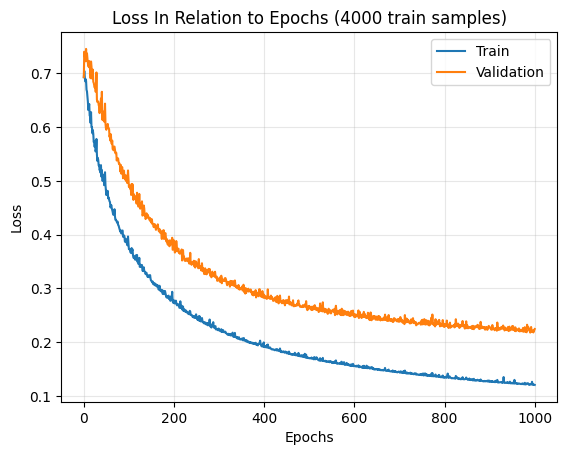

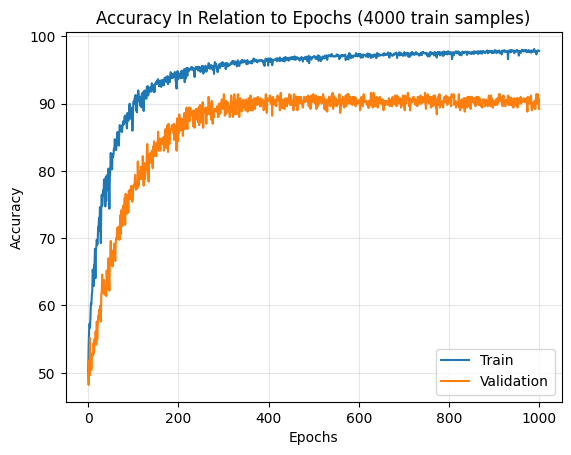

SUM OF WEIGHTS: 3324.165886461221
969


In [11]:
logistic.test()
print(f"SUM OF WEIGHTS: {sum(abs(logistic.weights))}")
print(len(logistic.weights))

### Using scikit-learn's Logistic Regression Model for performance comparison 

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegression as SKLearnLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

diagrams = logistic.X_train
labels = logistic.y_train

diagrams2 = logistic.X_test
labels2 = logistic.y_test

print(diagrams.shape, labels.shape)
print(diagrams2.shape, labels2.shape)

(4000, 969) (4000,)
(500, 969) (500,)


In [17]:
model = SKLearnLR(max_iter=5000)
model.fit(diagrams, labels)

predictions = model.predict(diagrams2)

accuracy = accuracy_score(labels2, predictions)
print("Test accuracy: ", accuracy)

Test accuracy:  0.754
